# Deep Q-Learning

In this part we will cover Deep Q-Learning, which is basically Q-learning with neural networks.

We will cover:
- Bellman Equation
- Neural Networks role in Deep Q-Learning

And then we will make a whole Deep Q-Learning algorithm using the library [Pytorch](https://pytorch.org/) and the environment framework [OpenAI-Gym](https://gym.openai.com/).

## The Bellman Equation

![bellman](./img/bellman_equation.png)

The Bellman Equation tells us how to update our Q-table after each step we take. To summarize this equation, the agent updates the current perceived value with the estimated optimal future reward which assumes that the agent takes the best current known action. In an implementation, the agent will search through all the actions for a particular state and choose the state-action pair with the highest corresponding Q-value.

This function allows us to determine the expected action based on states.\
In this exercice we will use a slightly modified version of the Bellman Equation adapted for [deterministic environments](https://www.doc.ic.ac.uk/project/examples/2005/163/g0516334/environ.html) such as the one we will be using.

## Neural Networks role in Deep Q-Learning

While vanilla Q-Learning might be sufficient for learning how to perform in simple environment, its perfromance will drop off considerably in more complex and sophisticated environments.\
The iterative process of updating the Q-Values of each state-action pair on a larger state space will become exponentially inefficient.

Rather than using value iteration to compute Q-Values and find the optimal Q-Function, we can instead use a function approximator to estimate the optimal Q-Function.\
And you know what can do an excellent job at approximating functions ? That's right: deep neural networks.\
The neural network will be responsible for **evaluating** states. (ie. determine the expected reward of each action on a givent state)

By replacing the Q-Table by an artificial neural network, we get rid (somehow) of the exponentially expensiveness of the original Q-Table, allowing us to make our agent evolve in more complex environments.

## OpenAI Gym

Gym is an convenient framework for Reinforcement Learning as it provide a handful of environments for our Agent to evolve in.
Gym aims to be a standard in artificial intelligence benchmarking and hopes to standardize the way in which environments are defined in AI research publications, so that published research becomes more easily reproducible.
The environment we will be using in this exercice is [CartPole-V0](https://gym.openai.com/envs/CartPole-v0/).

## Let's Start !

Alright so first things first, let's import everything that we'll need.

In [5]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import random

---
Next, let's start building our Neural Network.

Implement the init fuction of the Deep Q Network.
We will have **2 fully connected layers** and **an output layer**.

Tips: [torch.nn.Linear](https://pytorch.org/docs/1.9.1/generated/torch.nn.Linear.html), [torch.optim](https://pytorch.org/docs/stable/optim.html)

In [6]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        # -- Setup the layers (3 lines) --
        self.fc1 = nn.Linear(input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.out = nn.Linear(fc2_dims, n_actions)
        # -- end of code --

        # -- Setup the optimizer and the loss function (2 lines) --
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.loss = nn.MSELoss()
        # -- end of code --

        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

---
Next let's implement the forward, you should know how to do it now.\
For the activation function, Relu is suggested for this exercise.

> ⚠️ Don't use the activation function on the output layers, we will interpret the result ourselves.

In [7]:
def forward(self, state):
# -- implement the forward (~4-8 lines) --
   state = F.relu(self.fc1(state))
   state = F.relu(self.fc2(state))
   state = self.out(state)
   return state
# -- end of code --
        

setattr(DeepQNetwork, "forward", forward)

---
And that's pretty much it for our network.

Now what we need is a class to define our Agent. The agent will be responsible for:
* Storing transitions. The Agent will need to memorize transitions as it is its learning material.
* Choose an actions. The Agent will take action on an epsilon-greedy based manner, ie. it will sometimes take random actions to get a wider variety of transitions to learn from.
* Learn from it's memory (ie. update the network)

Let's start the job by initializing our Agent class.\
We start by storing all our hyper parameters, as it's always a good idea to save them in case we'd need them in the future.\
Then we initialize our evaluation network, and the we init the memory with empty arrays.\
It might be advisable to make a Memory class dedicated to storing and batching transitions, however for the sake of simplicity on this exercice, we will use multiple arrays to store transitions. (You are of course free to implement one yourself if you feel like it)

Tips: [np.zeros](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html)

In [8]:
class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions, max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.replace_target = 100

        # -- We initialize our Network... (1 line) --
        self.Q_eval = DeepQNetwork(lr, input_dims, 64, 64 * 2, n_actions)
        # -- end of code --

        # -- ...and the Agent's memory (5 lines) --
        self.state_memory = np.zeros((max_mem_size, input_dims)) # /!\ Reminder: A state is also an array in itself
        self.new_state_memory = np.zeros((max_mem_size, input_dims))
        self.action_memory = np.zeros(max_mem_size)
        self.reward_memory = np.zeros(max_mem_size)
        self.terminal_memory = np.zeros(max_mem_size)
        # -- end of code --

---
Next, let's make a function allowing us to store transitions easily, this one is pretty straightforward.

In [9]:
def store_transition(self, state, action, reward, new_state, terminal):
    index = self.mem_cntr % self.mem_size
    
    # -- store the transition (5 lines) --
    self.state_memory[index] = state
    self.new_state_memory[index] = new_state
    self.reward_memory[index] = reward
    self.action_memory[index] = action
    self.terminal_memory[index] = terminal
    # -- end of code --
    
    self.mem_cntr += 1

setattr(Agent, "store_transition", store_transition)

---
Then, we need a function that will actually make a choice based on an observation.\
Remember the epsilon greedy method from the previous subject ? We need to sometime choose a random action according at a rate defined by our epsilon value, this will allow our Agent to explore unknown possibilities to acquire a wider variety of experience.

Tips: [torch.Tensor](https://pytorch.org/docs/stable/tensors.html), [torch.argmax](https://pytorch.org/docs/stable/generated/torch.argmax.html), [numpy.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)

In [10]:
def choose_action(self, observation) -> int:
    # -- Epsilon greedy choice (~7 lines) --
    n = random.random()
    if n > self.epsilon:
        state = T.as_tensor(observation).float()
        action = self.Q_eval.forward(state)
        return T.argmax(action).numpy()
    else:
        return random.sample(self.action_space, 1)[0]
    # -- end of code --

setattr(Agent, "choose_action", choose_action)

---
Here comes the toughest part of our exercice, we need the Agent to be able to learn.\
In terms of algorithm, it is pretty similar to the typical supervised learning: determine loss -> backward. The catch here is how we determine the loss.\
Basically here we want to move the estimate value of the current state toward the estimate value of the next state, so our target here will be the  (read this again if needed, it is important)

Let's break down the algorithm into multiple parts:
1. If not enough data in memory, return.
2. Retreive a batch of data.
3. Feedforward our batch to get the relevant parameters to compute the loss function.
4. Compute the target thanks to the Bellman equation: target = reward + gamma * max(next) (Tip: [torch.max](https://pytorch.org/docs/stable/generated/torch.max.html))
5. Compute loss and do the backward propagation.



In [11]:
def learn(self):
    # 1. If not enough data, return

    if self.mem_cntr < self.batch_size:
        return

    self.Q_eval.optimizer.zero_grad() # (we also reset the optimizer's gradients)

    # 2. Retreive a batch of data.

    max_mem = min(self.mem_cntr, self.mem_size)
    batch_index = np.arange(self.batch_size, dtype=np.int32)
    batch = np.random.choice(max_mem, self.batch_size, replace=False)

    # -- We initalize the batch (5 lines) (tip: use the batch variable set above) --
    state_batch = [self.state_memory[n] for n in batch] # np.array[self.state_memory[i] for i in batch_index]
    new_state_batch = [self.new_state_memory[n] for n in batch]#self.new_state_memory[batch]
    reward_batch = [self.reward_memory[n] for n in batch]#self.reward_memory[batch]
    terminal_batch = [self.terminal_memory[n] for n in batch]#self.terminal_memory[batch]
    action_batch = [self.action_memory[n] for n in batch]#self.action_memory[batch]
    # -- end of code --

    # 3. Feedforward

    # -- We get our relevant parameters for our loss function. (2-3 lines) --
    q_eval = self.Q_eval.forward(T.as_tensor(state_batch).float())
    q_next = self.Q_eval.forward(T.as_tensor(new_state_batch).float())
    # -- end of code --

    q_next[terminal_batch] = 0.0 # We set the expected reward of terminal states to 0

    # 4. Compute the target
    # -- We get our target (what we want to tilt our estimates towards) (1 line) --
    q_target = self.Q_eval.forward(T.as_tensor(state_batch).float()).detach().numpy()
    for i in batch_index:
        if terminal_batch[i]:
            q_target[i, int(action_batch[i])] = reward_batch[i]
        else:
            q_target[i, int(action_batch[i])] = reward_batch[i] + self.gamma * T.max(q_next[i]).item()
    q_target = T.as_tensor(q_target).float()
        # Correction note: we transform q_next from a (64, 2) to a (64,) by using T.max,
        # which will select only the highest expected values.
    # -- end of code --

    # 5. Backward
    
    loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
    loss.backward()
    self.Q_eval.optimizer.step()

    self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

setattr(Agent, "learn", learn)

---
Now is the moment of truth, run the cells below to start the training of your Agent.\
If everything is going well, your average score should be rapidly approaching 200, which is the highest score you can get on the CartPole environment used here.

In [12]:
env = gym.make('CartPole-v1')
agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=2, eps_end=0.01, input_dims=4, lr=0.0001)
scores, eps_history = [], []
n_games = 200

/Users/mcciupek/Documents/42/POC-IA-POOL/env/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [13]:
for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        if reward != 1:
            print(action, reward)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
        #if done:
        #    break
        agent.learn()
        observation = observation_
    scores.append(score)
    eps_history.append(agent.epsilon)
    avg_score = np.mean(scores[-30:])
    print('episode', i, '| score %.2f' % score, '| average score %.2f' % avg_score, '| epsilon %.2f' % agent.epsilon)

episode 0 | score 14.00 | average score 14.00 | epsilon 1.00
episode 1 | score 16.00 | average score 15.00 | epsilon 1.00
episode 2 | score 18.00 | average score 16.00 | epsilon 1.00
episode 3 | score 13.00 | average score 15.25 | epsilon 1.00
episode 4 | score 15.00 | average score 15.20 | epsilon 0.99


/Users/mcciupek/Documents/42/POC-IA-POOL/env/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


episode 5 | score 24.00 | average score 16.67 | epsilon 0.98
episode 6 | score 48.00 | average score 21.14 | epsilon 0.96
episode 7 | score 24.00 | average score 21.50 | epsilon 0.95
episode 8 | score 21.00 | average score 21.44 | epsilon 0.94
episode 9 | score 19.00 | average score 21.20 | epsilon 0.93
episode 10 | score 40.00 | average score 22.91 | epsilon 0.91
episode 11 | score 16.00 | average score 22.33 | epsilon 0.90
episode 12 | score 19.00 | average score 22.08 | epsilon 0.89
episode 13 | score 19.00 | average score 21.86 | epsilon 0.88
episode 14 | score 19.00 | average score 21.67 | epsilon 0.87
episode 15 | score 14.00 | average score 21.19 | epsilon 0.86
episode 16 | score 20.00 | average score 21.12 | epsilon 0.85
episode 17 | score 12.00 | average score 20.61 | epsilon 0.85
episode 18 | score 23.00 | average score 20.74 | epsilon 0.83
episode 19 | score 26.00 | average score 21.00 | epsilon 0.82
episode 20 | score 34.00 | average score 21.62 | epsilon 0.80
episode 21 | 

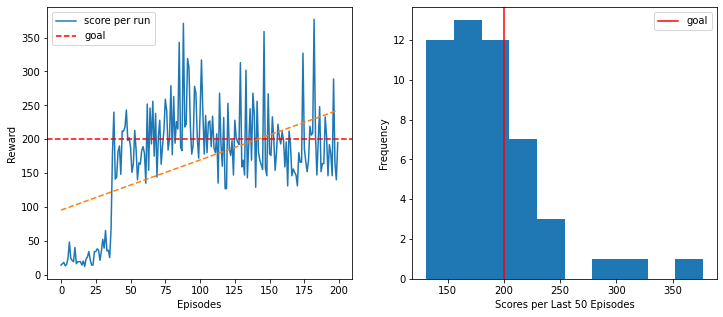

In [14]:
import matplotlib.pyplot as plt

def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    # clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(200, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(200, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

plot_res(scores)

---
If you saw an improvement during the training of your agent, then congratulation ! You made it !
Now, wanna see your Agent in action ? Run this cell below to watch your Agent play 5 games of CartPole.

> DISCLAIMER ! Gym is very wanky with Jupyter, do not interrupt this cell and wait for it to finish by itself or the render window might never close.

In [15]:
from pyglet.gl import *

ImportError: Can't find framework OpenGL.

In [23]:
new_env = gym.make('CartPole-v1')
for i in range(5):
    score = 0
    done = False
    observation = new_env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = new_env.step(action)
        score += reward
        observation = observation_
        new_env.render()
    print('Game', i, 'Score:', score)
new_env.close()

ImportError: 
    Error occurred while running `from pyglet.gl import *`
    HINT: make sure you have OpenGL install. On Ubuntu, you can run 'apt-get install python-opengl'.
    If you're running on a server, you may need a virtual frame buffer; something like this should work:
    'xvfb-run -s "-screen 0 1400x900x24" python <your_script.py>'
    

# Conclusion

Seeing your first Deep-Q-learning algorithm in action is pretty cool isn't it ? 

Let's resume what we learned in this subject:
* Q-Learning is fine, but not enough when increasing complexity.
* Artificial neural networks being good at approximating functions, they are the perfect match when it comes to replacing the Q-Table by something more viable.
* The Bellman Equation makes the learning possible by allowing us to shift the Q-Value of a state-action pair toward the Q-Value of the next state-action.
* Reinforcement Learning is cool.

Congrats on concluding this subject ! I hope that you enjoyed it and learned a lot of stuff.\
For those tough boys(and girls) that want EVEN MORE Reinforcement Learning action, the last subject of today will give you carte blanche to try and solve an harder environment.